# Searching
Try running it in a live notebook for animation!

* peakSearch
* bracketSearch
* binarySearch

In [1]:
# Reload modules every time code is called. Set autoreload 0 to disable
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)

from lightlab.util.search import peakSearch, binarySearch, SearchRangeError

In [2]:
livePlots = False

## You want to find a peak? Sweeping is not good enough

Text(0.5,1,'Poor, low-res sampling of underlying peak')

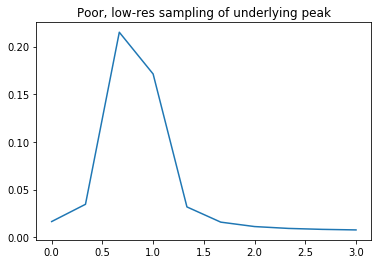

In [3]:
center = .82
amp = .7
fwhm = .2

defaultNoise = amp * 5e-3
noise = defaultNoise

assertionTolerance = .2

def myPeakedFun(x):
    y = amp / (1 + (2 * (x - center) / fwhm) ** 2) + noise * np.random.randn()
    return y
xq = np.linspace(0,3, 10)
plt.plot(xq, myPeakedFun(xq))
plt.title('Poor, low-res sampling of underlying peak')


## Peak search
This demonstrates noise tolerance when `nSwarm` is greater than 3

In [4]:
for noi, nSwarm in zip([defaultNoise, 5e-2], [3, 7]):
    noise = noi
    xPeak, yPeak = peakSearch(evalPointFun=myPeakedFun, startBounds=[0,3],
                              nSwarm=nSwarm, xTol=assertionTolerance/4, livePlot=livePlots)
    assert abs(xPeak - center) < assertionTolerance
    assert abs(yPeak - amp) < assertionTolerance
noise = defaultNoise

## Interactive peak descent through binary search

In [5]:
binSearchOpts = dict(evalPointFun=myPeakedFun, xTol=.005, livePlot=livePlots)

### This is easy, well bounded

In [6]:
rightBounds = [xPeak, 3]
leftBounds = [0, xPeak]
hwhmKwargs = dict(targetY=0.5*yPeak, **binSearchOpts)
xRightHalf = binarySearch(startBounds=rightBounds, **hwhmKwargs)
xLeftHalf = binarySearch(startBounds=leftBounds, **hwhmKwargs)
assert abs(xLeftHalf - (center - fwhm/2)) < assertionTolerance
assert abs(xRightHalf - (center + fwhm/2)) < assertionTolerance

### Non-monotonic but still well defined
There is only one value in the domain that satisfies. It starts off bracketed

No test for when there is a peak in the middle and it starts *not* bracketed, 
i.e. if rightStart fwhm was 0.75

To handle this, bracketSearch would have to report that it bracketed on both sides

In [7]:
rightStart = center + fwhm*.4
for leftStart in [0, center - fwhm, center - 0.6 * fwhm]:
    xLeftHalf = binarySearch(startBounds=[leftStart, rightStart], **hwhmKwargs)
    assert abs(xLeftHalf - (center - fwhm/2)) < assertionTolerance

### Bad bound conditioning saved by `bracketSearch`

In [8]:
# Starts outside, but pretty easy
xLeftHalf = binarySearch(startBounds=[0, xPeak/4], **hwhmKwargs)
assert abs(xLeftHalf - (center - fwhm/2)) < assertionTolerance

# Very bad domain (This takes a long time)
# noise = 0
# xLeftHalf = sUtil.binarySearch(startBounds=[0, .02], **hwhmKwargs)
# assert abs(xLeftHalf - (center - fwhm/2)) < assertionTolerance

# Target very close to peak
noise = defaultNoise / 10 # turn down noise a little bit
for trialAgainstNoise in range(5):
    try:
        xRightOnPeak = binarySearch(startBounds=[0, xPeak/4], targetY=0.99*amp, **binSearchOpts)
        break
    except RangeError as err:
        if 'probably noise' in err.args[0]:
            continue
        else:
            raise err
else:
    raise Exception('We tried a lot but noise killed this one')
assert abs(xRightOnPeak - center) < assertionTolerance
noise = defaultNoise


### Graceful failures

In [9]:
# Targeting something too high
goodAsItGets = binarySearch(startBounds=[0, center + .5 * fwhm], targetY=2, **binSearchOpts)
assert abs(goodAsItGets - center) < assertionTolerance
goodAsItGets = binarySearch(startBounds=[center, 3], targetY=2, **binSearchOpts)
assert abs(goodAsItGets - center) < assertionTolerance

2018-04-11 18:36:03,557 - WARNING - lightlab:
	Failed to bracket targetY=2. Returning best guess
2018-04-11 18:36:03,562 - WARNING - lightlab:
	Failed to bracket targetY=2. Returning best guess


### These should generate errors

In [10]:
# Targeting outside of hard constrain domain
try:
    binarySearch(startBounds=[xPeak, xPeak+.1], targetY=0, hardConstrain=True, **binSearchOpts)
    assert False
except SearchRangeError as err:
    assert err.args[1] == 'low'